# Downloading Datset

Update the gdown first so that it can download large-sized file

In [1]:
!pip install --upgrade --no-cache-dir gdown

Downloading the dataset

In [2]:
!gdown https://drive.google.com/uc?id=1nlC561JoAyFjMg9cuGyGf_9h77yRgydW

Downloading...
From: https://drive.google.com/uc?id=1nlC561JoAyFjMg9cuGyGf_9h77yRgydW
To: /content/traffic_sign.zip
100% 40.1M/40.1M [00:00<00:00, 242MB/s]


In [3]:
!unzip -q -o traffic_sign.zip

# Imports

In [4]:
import matplotlib.pyplot as plt
import cv2
import os
from skimage.feature import hog

In [5]:
import torch
import numpy as np

torch.manual_seed(1337)
np.random.seed(1337)

# Dataset Preparation

Extracting the HOG feature for each image

(576,)


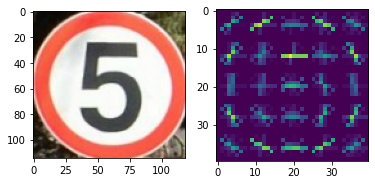

In [6]:

root = 'traffic_sign'
folders = os.listdir(root)

for folder in folders[5:]:
    folderpath = os.path.join(root, folder)
    if not os.path.isdir(folderpath):
        continue
    
    files = os.listdir(folderpath)
    for f in files[9:]:
        filename = os.path.join(folderpath, f)
        img = cv2.imread(filename)
        
        resized = cv2.resize(img, (40,40))
        feat, hog_image = hog(resized, orientations=9, pixels_per_cell=(8, 8), 
                    cells_per_block=(2, 2), visualize=True, multichannel=True)
        print(feat.shape)
        plt.figure()
        plt.subplot(1,2,1)
        plt.imshow(img[:,:,::-1])
        plt.subplot(1,2,2)
        plt.imshow(hog_image)
        break
    break
    

## Process all files and split into Training set and Test set

In [7]:
root = 'traffic_sign'
folders = os.listdir(root)
folders = [x for x in folders if os.path.isdir(os.path.join(root, x))]

features_train = []
labels_train = []
features_test = []
labels_test = []

for label, folder in enumerate(folders):
    folderpath = os.path.join(root, folder)
    
    files = os.listdir(folderpath)
    np.random.shuffle(files)

    k = 0
    n_test = 20
    for f in files:
        filename = os.path.join(folderpath, f)
        img = cv2.imread(filename)
        
        resized = cv2.resize(img, (40,40))
        feat, hog_image = hog(resized, orientations=9, pixels_per_cell=(8, 8), 
                    cells_per_block=(2, 2), visualize=True, multichannel=True)

        k+=1
        if k>n_test:
            features_train.append(feat)
            labels_train.append(label)
        else:
            features_test.append(feat)
            labels_test.append(label)
    
features_train = np.array(features_train).astype(np.float32) #pytorch only accept float32
labels_train = np.array(labels_train)

features_test = np.array(features_test).astype(np.float32)
labels_test = np.array(labels_test)

## Split the training data into training and validation

In [8]:
order = [x for x in range(features_train.shape[0])]
np.random.shuffle(order)

features_train = features_train[order]
labels_train = labels_train[order]

val_ratio = 0.2
n_val = int(val_ratio*features_train.shape[0])

features_val = features_train[:n_val]
features_train = features_train[n_val:]
labels_val = labels_train[:n_val]
labels_train = labels_train[n_val:]

In [9]:
print(features_train.shape)
print(features_val.shape)
print(features_test.shape)

(1568, 576)
(392, 576)
(200, 576)


# Dataset Loader

In [10]:
from torch.utils.data import Dataset

class TrafficSignDataset(Dataset):

    def __init__(self, features, labels):
        
        self.features = features
        self.labels = labels
    
    def __len__(self):
        return len(self.features)

    def __getitem__(self, i):
        feat, label = self.features[i], self.labels[i]
        return feat, label

## Test loading the dataset

In [11]:
from torch.utils.data import DataLoader

batch_size = 16

trainset = TrafficSignDataset(features_train, labels_train)
train_loader = DataLoader(dataset=trainset,
                          batch_size=batch_size,
                          shuffle=True, num_workers=2)


valset = TrafficSignDataset(features_val, labels_val)
val_loader = DataLoader(dataset=valset,
                          batch_size=1,
                          shuffle=True, num_workers=2)


In [12]:
for i, (x,y) in enumerate(train_loader):
    print(x.shape, y.shape)
    break

torch.Size([16, 576]) torch.Size([16])


# Model

In [13]:
import torch
import torch.nn as nn

class Net(nn.Module):
    def __init__(self, feat_size, n_class):
        super(Net, self).__init__()

        self.relu = nn.ReLU(inplace=True)
        self.layer1 = torch.nn.Linear(feat_size, 128)
        self.layer2 = torch.nn.Linear(128, 64)
        self.layer3 = torch.nn.Linear(64, 16)
    
        self.classifier =  torch.nn.Linear(16, n_class)
        
    def forward(self, x):
        relu = self.relu
        
        x = relu(self.layer1(x))
        x = relu(self.layer2(x))
        x = relu(self.layer3(x))

        out = relu(self.classifier(x))

        return out

## Test running the model

In [14]:
predictor = Net(features_train.shape[1], 10)
pred = predictor(x)

In [15]:
print(torch.argmax(pred, dim=1))
print(y)

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
tensor([0, 6, 7, 8, 3, 0, 8, 1, 5, 7, 5, 6, 6, 2, 6, 4])


# Training

In [16]:
from torch.nn.functional import cross_entropy

def training(model, optimizer, data_loader, objective_function, device, max_iter=-1):
    model.train()

    for i, (x,y) in enumerate(data_loader):
        x = x.to(device)
        y = y.to(device)
        
        logits = model(x)
        
        loss = objective_function(logits, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i==max_iter:
            break
    
    model.eval()

In [17]:

cpu = torch.device('cpu')
def count_acc(logits, label, device = cpu):
    pred = torch.argmax(logits, dim=1)
    return (pred == label).to(device).type(torch.FloatTensor).mean().item()

@torch.no_grad()
def evaluation(model, data_loader, objective_function, device, max_iter=-1):
    model.eval()

    loss_values = []
    accuracy_values = []

    for i, (x,y) in enumerate(data_loader):
        
        x = x.to(device)
        y = y.to(device)

        with torch.no_grad():
            
            logits = model(x)

            loss = objective_function(logits, y)
            acc = count_acc(logits, y, device)

        loss_values.append(loss.item())
        accuracy_values.append(acc)

        if i==max_iter:
            break

    loss = np.mean(loss_values)
    accuracy = np.mean(accuracy_values)

    return loss, accuracy

In [18]:
predictor = Net(features_train.shape[1], 10)
pred = predictor(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
predictor.to(device)

optimizer = torch.optim.Adam(predictor.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.5)

In [19]:
epochs = 10
model_checkpoint = 'best_model.pth'

best_acc = 0
for e in range(epochs):
    training(predictor, optimizer, train_loader, cross_entropy, device, max_iter=-1)
    
    loss, acc = evaluation(predictor, val_loader, cross_entropy, device, max_iter=-1)
    scheduler.step()

    print('epoch %d loss=%f acc=%f'%(e, loss, acc))
    
    if acc>=best_acc:
        predictor.eval()
        torch.save(predictor.state_dict(), model_checkpoint)
        best_acc = acc

epoch 0 loss=1.628076 acc=0.602041
epoch 1 loss=0.947301 acc=0.696429
epoch 2 loss=0.697066 acc=0.775510
epoch 3 loss=0.551030 acc=0.801020
epoch 4 loss=0.464987 acc=0.834184
epoch 5 loss=0.426818 acc=0.836735
epoch 6 loss=0.400421 acc=0.844388
epoch 7 loss=0.388673 acc=0.841837
epoch 8 loss=0.381420 acc=0.844388
epoch 9 loss=0.375097 acc=0.844388


# Loading the best model and test the trained model

In [20]:
predictor.load_state_dict(torch.load(model_checkpoint))
predictor.to(device)

testset = TrafficSignDataset(features_test, labels_test)
test_loader = DataLoader(dataset=testset,
                          batch_size=1,
                          shuffle=False, num_workers=2)

loss, acc = evaluation(predictor, val_loader, cross_entropy, device, max_iter=-1)
print('val:', loss, acc)
loss, acc = evaluation(predictor, test_loader, cross_entropy, device, max_iter=-1)
print('test:', loss, acc)

val: 0.3750973036566931 0.8443877551020408
test: 0.4886623803579823 0.8
